## Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [40]:
# Load pickled data
import pickle
from os import path
import tensorflow as tf
import cv2
import numpy as np

data_dir = '/Users/xi/Downloads/data/traffic-signs-data'
work_dir = '/Users/xi/Documents/coding/udacity_self_driving/CarND-Traffic-Sign-Classifier-Project'

training_file = path.join(data_dir, 'train.p')
validation_file= path.join(data_dir, 'valid.p')
testing_file = path.join(data_dir, 'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [32]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import csv

n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_test.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
map_id_class = {}
signnames_csv_file = open(path.join(work_dir, 'signnames.csv'), 'r')
reader = csv.reader(signnames_csv_file)
next(reader, None)
for row in reader:
    map_id_class[int(row[0])] = row[1]
signnames_csv_file.close()
n_classes = len(map_id_class)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

(array([  180.,  1980.,  2010.,  1260.,  1770.,  1650.,   360.,  1290.,
         1260.,  1320.,  1800.,  1170.,  1890.,  1920.,   690.,   540.,
          360.,   990.,  1080.,   180.,   300.,   270.,   330.,   450.,
          240.,  1350.,   540.,   210.,   480.,   240.,   390.,   690.,
          210.,   599.,   360.,  1080.,   330.,   180.,  1860.,   270.,
          300.,   210.,   210.]),
 array([  0.        ,   0.97674419,   1.95348837,   2.93023256,
          3.90697674,   4.88372093,   5.86046512,   6.8372093 ,
          7.81395349,   8.79069767,   9.76744186,  10.74418605,
         11.72093023,  12.69767442,  13.6744186 ,  14.65116279,
         15.62790698,  16.60465116,  17.58139535,  18.55813953,
         19.53488372,  20.51162791,  21.48837209,  22.46511628,
         23.44186047,  24.41860465,  25.39534884,  26.37209302,
         27.34883721,  28.3255814 ,  29.30232558,  30.27906977,
         31.25581395,  32.23255814,  33.20930233,  34.18604651,
         35.1627907 ,  36.1395

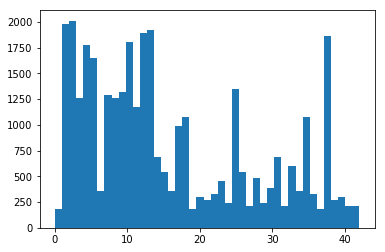

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
        
plt.hist(y_train, bins=n_classes)

No entry


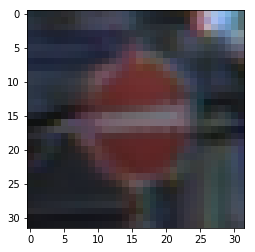

In [42]:
show_class = 17
print(map_id_class[show_class])
for i in range(n_train):
    if y_train[i] == show_class:
        image = X_train[i].squeeze()
        plt.imshow(image)
        break

---

## Step 2: Design and Test a Model Architecture

Train and test the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set

* Transfer the image to grayscale
* Normalize the image to value between [-0.5, 0.5]

In [36]:
from numpy import newaxis

def pre_process(images):
    # process images and return as a numpy array
    processed_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY, dstCn=1)
        img = img / 255 - 0.5
        processed_images.append(img)
    processed_images = np.asarray(processed_images)
    return processed_images[..., newaxis]
    
X_train = pre_process(X_train)
X_valid = pre_process(X_valid)
X_test = pre_process(X_test)

### Data Augmentation

In [38]:
ang_range = 20
trans_range = 5
shear_range = 10

def transform(img):
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,channel = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
    
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    return img
    
def augmentation(old_images, num):
    new_images = []
    rand_idx = np.random.randint(old_images.shape[0], size=num)
    for i in range(num):
        img = transform(old_images[rand_idx[i]])
        new_images.append(img)
    return np.array(new_images)[..., newaxis]
    
data_num_per_class = np.bincount(y_train)
required_num = np.amax(data_num_per_class)

print("Create new data...")
for i in range(n_classes):
    num = required_num - data_num_per_class[i]
    if num > 0:
        new_images = augmentation(X_train[y_train == i], num)
        X_train = np.append(X_train, new_images, axis=0)
        y_train = np.append(y_train, np.full((num), i))
print("Done.")

Create new data...
Done.


### Model Architecture

In [129]:
# Constants
conv1_depth = 6
conv2_depth = 16
fc1_size = 120
fc2_size = 84
output = n_classes

mu = 0
sigma = 0.1
keep_prob = 0.8

In [130]:
from tensorflow.contrib.layers import flatten

def inference(input):
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    with tf.name_scope('Conv1') as scope:
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 5x5x16.
    with tf.name_scope('Conv2') as scope:
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    with tf.name_scope('Fc1') as scope:
        fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        fc1   = tf.nn.relu(fc1)
        fc1   = tf.nn.dropout(fc1, keep_prob)
        
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    with tf.name_scope('Fc2') as scope:
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)
        fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    with tf.name_scope('Output') as scope:
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Model Training

In [140]:
rate = 0.001
EPOCHS = 15
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = inference(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [141]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [142]:
from sklearn.utils import shuffle

saver = tf.train.Saver()
assert (len(X_train) == len(y_train))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {}: Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
    test_accuracy = evaluate(X_test, y_test)
    print()
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    saver.save(sess, './classifier')
    print("Model saved")

Training...
EPOCH 1: Validation Accuracy = 0.637
EPOCH 2: Validation Accuracy = 0.745
EPOCH 3: Validation Accuracy = 0.805
EPOCH 4: Validation Accuracy = 0.826
EPOCH 5: Validation Accuracy = 0.825
EPOCH 6: Validation Accuracy = 0.848
EPOCH 7: Validation Accuracy = 0.849
EPOCH 8: Validation Accuracy = 0.872
EPOCH 9: Validation Accuracy = 0.881
EPOCH 10: Validation Accuracy = 0.874
EPOCH 11: Validation Accuracy = 0.886
EPOCH 12: Validation Accuracy = 0.883
EPOCH 13: Validation Accuracy = 0.886
EPOCH 14: Validation Accuracy = 0.889
EPOCH 15: Validation Accuracy = 0.881

Test Accuracy = 0.874
Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

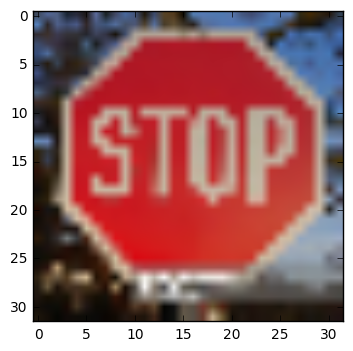

In [134]:
import matplotlib.image as mpimg

test_dir = path.join(work_dir, 'examples')
test_images = []
for i in range(5):
    img = mpimg.imread(path.join(test_dir, 'german_traffic_sign%d.jpg' % (i + 1)), cv2.IMREAD_COLOR)
    img = cv2.resize(img, image_shape[0:2])
    test_images.append(img)
plt.imshow(test_images[0], cmap='gray')
test_images = pre_process(np.asarray(test_images))
test_labels = np.asarray([14, 28, 17, 27, 11])

### Predict the Sign Type for Each Image

In [143]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logits_value = sess.run(logits, feed_dict={x: test_images, y: test_labels})
    test_accuracy = evaluate(test_images, test_labels)
    print("Accuracy on web image: {}".format(test_accuracy))

Accuracy on web image: 1.0


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [144]:
with tf.Session() as sess:
    top_k_val, top_k_idx = sess.run(tf.nn.top_k(logits_value, k=5))
for i in range(top_k_idx.shape[0]):
    print("Image %d: %s"%(i+1, map_id_class[test_labels[i]]), list(map_id_class[j] for j in top_k_idx[i]))

Image 1: Stop ['Keep right', 'General caution', 'Road work', 'Traffic signals', 'Dangerous curve to the right']
Image 2: Children crossing ['Children crossing', 'Road work', 'Beware of ice/snow', 'Right-of-way at the next intersection', 'Slippery road']
Image 3: No entry ['No entry', 'Stop', 'Turn left ahead', 'No passing for vehicles over 3.5 metric tons', 'Vehicles over 3.5 metric tons prohibited']
Image 4: Pedestrians ['Traffic signals', 'Pedestrians', 'General caution', 'Road narrows on the right', 'Road work']
Image 5: Right-of-way at the next intersection ['Right-of-way at the next intersection', 'Road work', 'Slippery road', 'Beware of ice/snow', 'Children crossing']
